# COMP30027 Machine Learning, 2022 Semester 1

## Assignment 1: Naive Bayes Leaner for Adult Database


## Part 1: Base code [8 marks]

Instructions
1. Do **not** shuffle the data set
2. Treat the attributes as they are(e.g., do **not** convert numeric attributes to categorical or categorical to numeric). Implement a Naive Bayes classifier with appropriate likelihood function for each attribute.
3. You should implement the Naive Bayes classifier from scratch. Do **not** use existing implementations/learning algorithms.
4. You CANNOT have more than one train or predict function. Both continuous numeric attributes and categorical ones should be trained in one `train()` function, similarly for the `predict()`.  
5. Apart from the instructions in point 3, you may use libraries to help you with data reading, representation, maths or evaluation
6. Ensure that all and only required information is printed, as indicated in the final three code cells. Failure to adhere to print the required information will result in **[-1 mark]** per case. *(We don't mind details like you print a list or several numbers -- just make sure the information is displayed so that it's easily accessible)
7. You may change the prototypes of these functions, and you may write other functions, according to your requirements. We would appreciate it if the required functions were prominent/easy to find. 
8. You should add adequate comments to make your code easily comprehendible.*

In [1]:
# Importing necessary libraries for this project
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scipy.stats import norm 
from math import log, exp, sqrt, pi
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.utils import shuffle

In [2]:
# This function should prepare the data by reading it from a file and converting it into a useful format for training and testing
# and implement 90-10 splitting as specified in the project description.

def preprocess(filename):
    """
    Parameters:
        - filename = path of file to access
    
    1) Read csv file into a dataframe
    2) Split the dataframe into training and testing set (90-10) 
        (WITHOUT SHUFFLING)
    
    Return training and test datasets for X and y
    """
    # Reading csv file into dataframe
    data = pd.read_csv(filename, sep = ',')
    
    # Splitting data into 90-10 without shuffling
    #     X = attribute values; y = labels 
    X, y = data.iloc[:,:-1] , data.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle = False)
    
    return X_train, X_test, y_train, y_test

In [3]:
# This function should calculate prior probabilities and likelihoods (conditional probabilities) from the training data and using
# to build a naive Bayes model

def train(X_train, y_train, num_att, nom_att):
    """
    Parameters:
        - X_train = training data of attributes
        - y_train = class labels of training data
        - num_att = numerical attribute column names
        - nom_att = nominal attribute column names
    
    Using training dataset:
    - Compute prior probabilities and conditional probabilities for Naive Bayes model
        - Nominal attributes (missing values will be a new category)
        - Numeric attributes to fit Gaussian distribution
    
    Return a dictionary containing:
        (FOR CLASS LABELS)
        - Probability of class labels
            - Key --> class label
            - Value --> probability of the class label
    
        (FOR NOMINAL ATTRIBUTES)
        - Conditional probabilities for each value in the nominal attribute(i) and put in dictionary:
            - Key --> (attribute, value of attribute, class label)
            - Value --> conditional probability of value of attribute given class label
        - ***Did Simple Option probability smoothing method where all 0 probabilities were replaced with 
            an error constant was 0.0000001***
        
        (FOR NUMERICAL ATTRIBUTES)
        - Mean and SD of each numerical attribute(i) and put in dictionary:
            - Key --> (attribute, class label, Mean or SD)
            - Value --> Mean or SD of attribute containing specific class label
    """
    
    # Getting Priors aka class label probabilities
    prior_dict = dict(y_train.value_counts(normalize = True))

    # Calculate conditional probabilities for nom attributes
    nom_dict = nom_probs(pd.concat([X_train[nom_att],y_train], axis = 1))
    
    # Calculate mean and SD for num attributes
    num_dict = num_probs(pd.concat([X_train[num_att],y_train], axis = 1))
    
    # Add all dictionaries together
    NB_dict = {**prior_dict, **nom_dict, **num_dict}
    
    return NB_dict

In [4]:
def nom_probs(data):
    """
    Parameters:
        - data = subset of training data containing only nominal attributes and class label
    
    Calculate conditional probabilities for each value in the nominal attribute(i) and put in dictionary:
        - Key --> (attribute, value of attribute, class label)
        - Value --> conditional probability of value of attribute given class label
        
    To calculate all conditional probabilities, we use NB so we need:
        (1) P(class labels)
        (2) P(class labels|Atttribute(i)(j))
        (3) P(Atttribute(i)(j)) 
        (*) P(Attr(i)(j)|class label) = P(class label|Attr(i)(j)) * P(Attr(i)(j)) / P(class label)
                                    = (2)*(3)/(1)
    
    Finally, apply Simple Option probability smoothing method where all 0 probabilities were replaced with 
        an error constant was 0.0000001
    
    Returns a dictionary containing all conditional probabilities of each value of every attribute given class labels
    """
    LESS_EQ50 = " <=50K"
    GREATER50 = " >50K"
    ERROR_CONST = 0.0000001
    
    # (1) Getting P(class labels): P(" <=50K") and P(" >50K")
    less_eq_50, greater_50 = data["label"].value_counts(normalize = True)
    
    # Store all required conditional probabilities into dictionary
    nom_dict = {}
    
    # Iterate through every values of each attribute to calculate (2) and (3) 
    for col in data.iloc[:,:-1]:
        attr = data[col]
        
        # Getting (3) for all values in this attribute in a dictionary format for easy use
        val_probs = dict(attr.value_counts(normalize = True))
        
        # Getting (*) for each attribute value
        for value in val_probs.keys():
            
            # Calculating (2) P(" <=50K"|value), P(" >50K"|value) and putting them into dict
            #     **Account for 0 probabilities for class labels**
            p_labels = dict(data["label"].loc[data[col] == value].value_counts(normalize = True))
            
            # If only 1 key in p_labels --> other class label has to have prob of 0
            if(len(p_labels.keys()) == 1):
                
                # Add 0 for probability of other label which is not included
                if(list(p_labels.keys())[0] == LESS_EQ50):
                    p_labels[GREATER50] = 0
                else:
                    p_labels[LESS_EQ50] = 0
                    
            
            
            # Now that we have (1),(2), and (3), we can calculate (*) for this attribute
            # Calculate P(value| " <=50")
            p_val_lessEq50 = p_labels[LESS_EQ50] * val_probs[value] / less_eq_50
            
            # Calculate P(value| " >50")
            p_val_greater50 = p_labels[GREATER50] * val_probs[value] / greater_50
            
            # Applying smoothing method
            if not p_val_lessEq50:
                p_val_lessEq50 = ERROR_CONST
            if not p_val_greater50:
                p_val_greater50 = ERROR_CONST
            
            # Add to the dict for collation
            nom_dict[(col, value, LESS_EQ50)] = p_val_lessEq50
            nom_dict[(col, value, GREATER50)] = p_val_greater50
    
    return nom_dict
        
            
    
    

In [5]:
def num_probs(data):
    """
    Parameters:
        - data = subset of training data containing only numerical attributes and class label
    
    Calculate Mean and SD of each numerical attribute(i) and put in dictionary:
        - Mean and SD of each numerical attribute(i) (ignore missing values)
            - Key --> (attribute, class label, Mean or SD)
            - Value --> Mean or SD of attribute containing specific class label
    
    Returns a dictionary of all Mean and SDs of every attribute of a specific class labels
    """
    
    LESS_EQ50 = " <=50K"
    GREATER50 = " >50K"
    
    # Store all required conditional probabilities into dictionary
    num_dict = {}
    
    # Iterate through every attribute to get Mean and SDs
    for col in data.iloc[:,:-1]:
        attr = data[col]
        
        # Separate all values in the attribute to specific class label (' <=50K',' >50K')
        less_eq_50 = data[col].loc[data["label"] == LESS_EQ50]
        greater_50 = data[col].loc[data["label"] == GREATER50]
    
        # Calculate mean and SD and put it into dictionary
        num_dict[(col, LESS_EQ50, "Mean")] = less_eq_50.mean()
        num_dict[(col, GREATER50, "Mean")] = greater_50.mean()
        num_dict[(col, LESS_EQ50, "SD")] = less_eq_50.std()
        num_dict[(col, GREATER50, "SD")] = greater_50.std()

    return num_dict
       

In [6]:
# This function should predict classes for new items in the testing data
def predict(NB_dict, X_test, num_att, nom_att):
    """
    Parameters:
        - NB_dict = dictionary containing all conditional probabilities and priors for NB Classifier calculation
        - X_test = testing data of attributes
        - num_att = numerical attribute column names
        - nom_att = nominal attribute column names
    
    Using Naive Bayes Classifier, to predict class labels for given X_test 
    (using Log for probabilities)
    
    ***We will ignore any missing numerical attributes and any new values in nominal attributes***
    (We do not want to skew any results from adding probabilities of new values 
        as our model did not train for that new value)
    
    Return 2 lists:
        - y_pred = predicted class labels with the row of each value corresponding to same row in X_test
        - y_pred_prob = both class label probabilities calculated for y_pred in tuple
            - [0] = predicted probability for " <=50"
            - [1] = predicted probability for " >50"
    """
    
    LESS_EQ50 = " <=50K"
    GREATER50 = " >50K"
    
    y_pred = []
    y_pred_prob = []

    # Iterate every row(instance) and get class labels
    for ind in X_test.index:
        
        # Initialize Conditional probabilities with priors first
        pred_p_lessEq50 = NB_dict[LESS_EQ50]
        pred_p_greater50 = NB_dict[GREATER50]
        
        # Go through every nominal attribute and include into probability of each class label
        for attr in nom_att:
            
            # Check if the value is not new
            if((attr, X_test[attr][ind], LESS_EQ50) in NB_dict):
                
                pred_p_lessEq50 *= NB_dict[(attr, X_test[attr][ind], LESS_EQ50)]
                pred_p_greater50 *= NB_dict[(attr, X_test[attr][ind], GREATER50)]
        
        
        # Go through every numerical attribute and include into probability of each class label
        for attr in num_att:
            
            # Check if missing value
            if(X_test[attr][ind]!= "?"):
                
                pred_p_lessEq50 *= norm(NB_dict[(attr, LESS_EQ50, "Mean")]
                                        ,NB_dict[(attr, LESS_EQ50, "SD")]).pdf(X_test[attr][ind])
                pred_p_greater50 *= norm(NB_dict[(attr, GREATER50, "Mean")]
                                        ,NB_dict[(attr, GREATER50, "SD")]).pdf(X_test[attr][ind])
        
        # Don't forget to log probabilities
        pred_p_lessEq50 = log(pred_p_lessEq50)
        pred_p_greater50 = log(pred_p_greater50)
        
        # Pick the highest probability and store it
        if(pred_p_lessEq50 > pred_p_greater50):
            y_pred.append(LESS_EQ50)

        elif(pred_p_lessEq50 < pred_p_greater50):
            y_pred.append(GREATER50)

        # In case we get same probabilities, we put out both in prediction to say both are equally likely
        else:
            y_pred.append((LESS_EQ50, GREATER50))
        
        # Add both probabilities to y_pred_prob
        y_pred_prob.append((pred_p_lessEq50, pred_p_greater50))
        
    return y_pred, y_pred_prob

In [7]:
# This function should evaliate the prediction performance by comparing your model’s class outputs to ground
# truth labels, return and output accuracy, confusion matrix and F1 score.

def evaluate(y_test, y_pred):
    """
    Evaluate prediction performance of model (print all results):
        - Get confusion matrix(2x2) (Positive --> " <=50K"; Negative --> " >50K")
            - [0][0] = TP
            - [0][1] = FN
            - [1][0] = FP
            - [1][1] = TN
        - Get Accuracy --> (TP + TN) / (TP + FP + FN + TN)
        - Get F1 score --> 2PR / (P + R)
            - P = TP / (TP + FP)
            - R = TP / (TP + FN)
    
    Return Confusion Matrix, Accuracy, F1 score
    """
    
    # Getting confusion matrix and printing where:
    #     - Positive --> " <=50K"
    #     - Negative --> " >50K"
    con_mat = confusion_matrix(y_test, y_pred, labels=[" <=50K", " >50K"])
    print("Confusion Matrix:")
    print(con_mat)
    
    # Get tp, fn, fp, tn
    tp, fn, fp, tn = con_mat.ravel()
    
    # Getting Accuracy and printing
    accuracy = (tp + tn) / (tp + fp + fn + tn)
    print("Accuracy: ", accuracy)
    
    # Getting F1 score
    # Get Precision(P)
    p = tp / (tp + fp)
    
    # Get Recall(R)
    r = tp / (tp + fn)
    
    # Calculate F1 score
    f1 = 2 * p * r / (p + r)
    print("F1 score: ", f1)
    
    return con_mat, accuracy, f1

In [8]:
# This cell should act as your "main" function where you call the above functions 
# on the full ADULT data set, and print the evaluation results. [0.33 marks]


########################################################################################################
# First, read in the data and apply your NB model to the ADULT data

# Read data and split into training and testing datasets
filename = 'dataset/adult.csv'
X_train, X_test, y_train, y_test = preprocess(filename)

# Finding numerical and nominal attributes manually
num_att = ["age", "education num", "hours per week"]
nom_att = X_train.drop(num_att,1).columns.values.tolist()

# Training model
NB_dict = train(X_train, y_train, num_att, nom_att)

# Predicting based on test data
y_pred, y_pred_prob = predict(NB_dict, X_test, num_att, nom_att)


########################################################################################################
# Second, print the full evaluation results from the evaluate() function
con_mat, accuracy, f1 = evaluate(y_test, y_pred)


########################################################################################################
# Third, print data statistics and model predictions, as instructed below 
# N is the total number of instances, F the total number of attributes, L the total number of labels
# The "class probabilities" may be unnormalized
# The "predicted class ID" must be in range (0, L)

print("Attribute vectors of instances [0, 1, 2]: \n - Instance[0]: ", list(X_train.iloc[0,:])
        , "\n - Instance[1]: ", list(X_train.iloc[1,:])
        , "\n - Instance[2]: ", list(X_train.iloc[2,:]) 
     ) # of the first three records in adult.csv

print("\nNumber of instances (N): ", (len(X_train) + len(X_test)))
print("Number of attributes (F): ", len(X_train.columns))
print("Number of labels (L): ", y_train.nunique())


# print out the prediction results of the last three instances
print("\n\nPredicted class log-probabilities for instance N-3: "
      + "\n "" <=50"": ", y_pred_prob[-3][0]
      , "\n "" >50"": ", y_pred_prob[-3][1]
     )
print("Predicted class ID for instance N-3: ", y_pred[-3])
print("\nPredicted class log-probabilities for instance N-2: "
      + "\n "" <=50"": ", y_pred_prob[-2][0]
      , "\n "" >50"": ", y_pred_prob[-2][1]
     )
print("Predicted class ID for instance N-2: ", y_pred[-2])
print("\nPredicted class log-probabilities for instance N-1: "
      + "\n "" <=50"": ", y_pred_prob[-1][0]
      , "\n "" >50"": ", y_pred_prob[-1][1]
     )
print("Predicted class ID for instance N-1: ", y_pred[-1])



Confusion Matrix:
[[69  8]
 [ 6 17]]
Accuracy:  0.86
F1 score:  0.9078947368421053
Attribute vectors of instances [0, 1, 2]: 
 - Instance[0]:  [68, ' ?', ' 1st-4th', 2, ' Divorced', ' ?', ' Not-in-family', ' White', ' Female', 20, ' United-States'] 
 - Instance[1]:  [39, ' State-gov', ' Bachelors', 13, ' Never-married', ' Adm-clerical', ' Not-in-family', ' White', ' Male', 40, ' United-States'] 
 - Instance[2]:  [50, ' Self-emp-not-inc', ' Bachelors', 13, ' Married-civ-spouse', ' Exec-managerial', ' Husband', ' White', ' Male', 13, ' United-States']

Number of instances (N):  1000
Number of attributes (F):  11
Number of labels (L):  2


Predicted class log-probabilities for instance N-3: 
  <=50:  -20.71689698193305 
  >50:  -19.556273652832147
Predicted class ID for instance N-3:   >50K

Predicted class log-probabilities for instance N-2: 
  <=50:  -25.33907063773019 
  >50:  -22.744589775643142
Predicted class ID for instance N-2:   >50K

Predicted class log-probabilities for instanc

## Part 2: Conceptual questions [8 marks for groups of 1] / [16 marks for groups of 2]


If you are in a group of 1, you should respond to Q1 and Q2.

If you are in a group of 2, you should respond to Q1, Q2, Q3 and Q4.

A response to a question should take about 100–250 words. You may need to develope codes or functions to help respond to the question here. 

#### NOTE: We strongly recommend <u>including figures or tables, etc.</u> to support your responses. The figures and tables inserted in Markdown cells must be reproducable by your code.

### Q1 [4 marks]
<u>Sensitivity</u> and <u>specificity</u> are two model evaluation metrics.  A good model should have both sensitivity and specificity high. Use the $2 \times 2$ confusion matrix returned by `evaluate()` to calculate the sensitivity and specificity. Do you see a difference between them? If so, what causes this difference? Provide suggestions to improve the model performance. 

In [9]:
# Write additional code here, if necessary (you may insert additional code cells)
# Get tp, fn, fp, tn
tp, fn, fp, tn = con_mat.ravel()

# Getting sensitivity --> TP / (TP + FN)
sensitivity = tp / (tp + fn)
print("sensitivity: ", sensitivity)

# Getting specificity --> TN / (TN + FP)
specificity = tn / (tn + fp)
print("specificity: ", specificity)

sensitivity:  0.8961038961038961
specificity:  0.7391304347826086


In [10]:
y_train.value_counts()

 <=50K    692
 >50K     208
Name: label, dtype: int64

We can see that there is a difference between sensitivity and specificity. The model was able to correctly identify instances where income is less than or equal to 50K better than instances where income is greater than 50K. The difference could be cause due to the fact that the training data were given almost 3.5 time more of " <=50K" labeled instances as compared to " >50K" labeled instances. 

To improve the model performance, specifically towards increasing the specificity, we could add more instances labeled " >50K" for the training data. 

As a whole, to improve model performance, instead of assuming all numerical attributes to have a Gaussian distribution, we actually visualize and see the numerical data to check if it follows a Gaussian distribution. For those that do not follow the Gaussian distribution, we can apply KDE instead to those numerical attributes for a more accurate result. 

We also see that some features are not independent according to our NB assumptions that all features are independent (inductive bias). A clear example would be "education num" and "education". The values in both attributes are highly correlated = 1. So, before applying NB, we should remove one of the attriubutes to remove as much correlated attributes as we can to fit the assumptions of NB. 

### Q2 [4 marks]
You can adopt different methods for training and/or testing, which will produce different results in model evaluation. 

(a) Instead of Gaussian, <u>implement KDE</u> for  $P(X_i|c_j)$ for numeric attributes $X_i$. Compare the evaluation results with Gaussian. Which one do you think is more suitable to model $P(X_i|c_j)$, Gaussian or KDE? Observe all numeric attributes and justify your answer.

You can choose an arbitrary value for kernel bandwidth $\sigma$ for KDE, but a value between 3 and 15 is recommended. You should write code to implement KDE, not call an existing function/method such as `KernelDensity` from `scikit-learn`.

(b) Implement <u>10-fold and 2-fold cross-validations</u>.  
	Observe the evaluation results in each fold and the average accuracy, recall and specificity over all folds. 
	Comment on what is the effect by changing the values of $m$ in $m$-fold cross validation. (You can choose either Gaussian or KDE Naive Bayes.)

#### QUESTION (a)

In [11]:

def predict_KDE(Xy_train, X_test, num_att, nom_att, SD):
    """
    Parameters:
        - Xy_train = training data of attributes and labels
        - X_test = testing data of attributes
        - num_att = numerical attribute column names
        - nom_att = nominal attribute column names
        - SD = kernal bandwidth chosen 
    
    Using Naive Bayes Classifier, to predict class labels for given X_test 
    (using Log for probabilities)
    
    However, for num attributes, we will implement KDE instead of Gaussian
        - Done while predicting
    
    Return a list:
        - y_pred = predicted class labels with the row of each value corresponding to same row in X_test
    """
    
    # Getting Priors aka class label probabilities
    prior_dict = dict(y_train.value_counts(normalize = True))

    # Calculate conditional probabilities for nom attributes
    nom_dict = nom_probs(pd.concat([X_train[nom_att],y_train], axis = 1))
    
    # Add all dictionaries together
    NB_dict = {**prior_dict, **nom_dict}
       
        
    # Predicting     
    LESS_EQ50 = " <=50K"
    GREATER50 = " >50K"
    
    y_pred = []
    n = len(Xy_train)

    # Iterate every row(instance) and get class labels
    for ind in X_test.index:
        
        # Initialize Conditional probabilities with priors first
        pred_p_lessEq50 = NB_dict[LESS_EQ50]
        pred_p_greater50 = NB_dict[GREATER50]
        
        # Go through every nominal attribute and include into probability of each class label
        for attr in nom_att:
            # Check if the value is not new
            if((attr, X_test[attr][ind], LESS_EQ50) in NB_dict):
                pred_p_lessEq50 *= NB_dict[(attr, X_test[attr][ind], LESS_EQ50)]
                pred_p_greater50 *= NB_dict[(attr, X_test[attr][ind], GREATER50)]
        
        # Go through every numerical attribute and implement KDE
        for attr in num_att:
            x = X_test[attr][ind]
            
            # Make sure x is not missing ("?")
            if(x != "?"):
            
                # Separate all values in the attribute to specific class label (' <=50K',' >50K')
                less_eq_50 = Xy_train[attr].loc[Xy_train["label"] == LESS_EQ50]
                greater_50 = Xy_train[attr].loc[Xy_train["label"] == GREATER50]

                # Calculating the KDE for each attribute and class label to be includeded into prediction probability
                # For " <=50" label
                kde = 0
                for xi in less_eq_50:
                    kde += (1/(SD * sqrt(2 * pi)) * exp(-0.5 * ((x-xi) / SD)**2))
                pred_p_lessEq50 *= (kde/n)

                # For " >50" label
                kde = 0
                for xi in greater_50:
                    kde += (1/(SD * sqrt(2 * pi)) * exp(-0.5 * ((x-xi) / SD)**2))
                pred_p_greater50 *= (kde/n)
                
        # Pick the highest probability and store it
        if(pred_p_lessEq50 > pred_p_greater50):
            y_pred.append(LESS_EQ50)

        elif(pred_p_lessEq50 < pred_p_greater50):
            y_pred.append(GREATER50)

        # In case we get same probabilities, we put out both in prediction to say both are equally likely
        else:
            y_pred.append((LESS_EQ50, GREATER50))
    
    return y_pred


In [12]:
training_data = pd.concat([X_train, y_train], axis = 1)
y_pred_KDE = predict_KDE(training_data, X_test, num_att, nom_att, 3)
con_mat_KDE, accuracy_KDE, f1_KDE = evaluate(y_test, y_pred_KDE)

Confusion Matrix:
[[76  1]
 [15  8]]
Accuracy:  0.84
F1 score:  0.9047619047619049


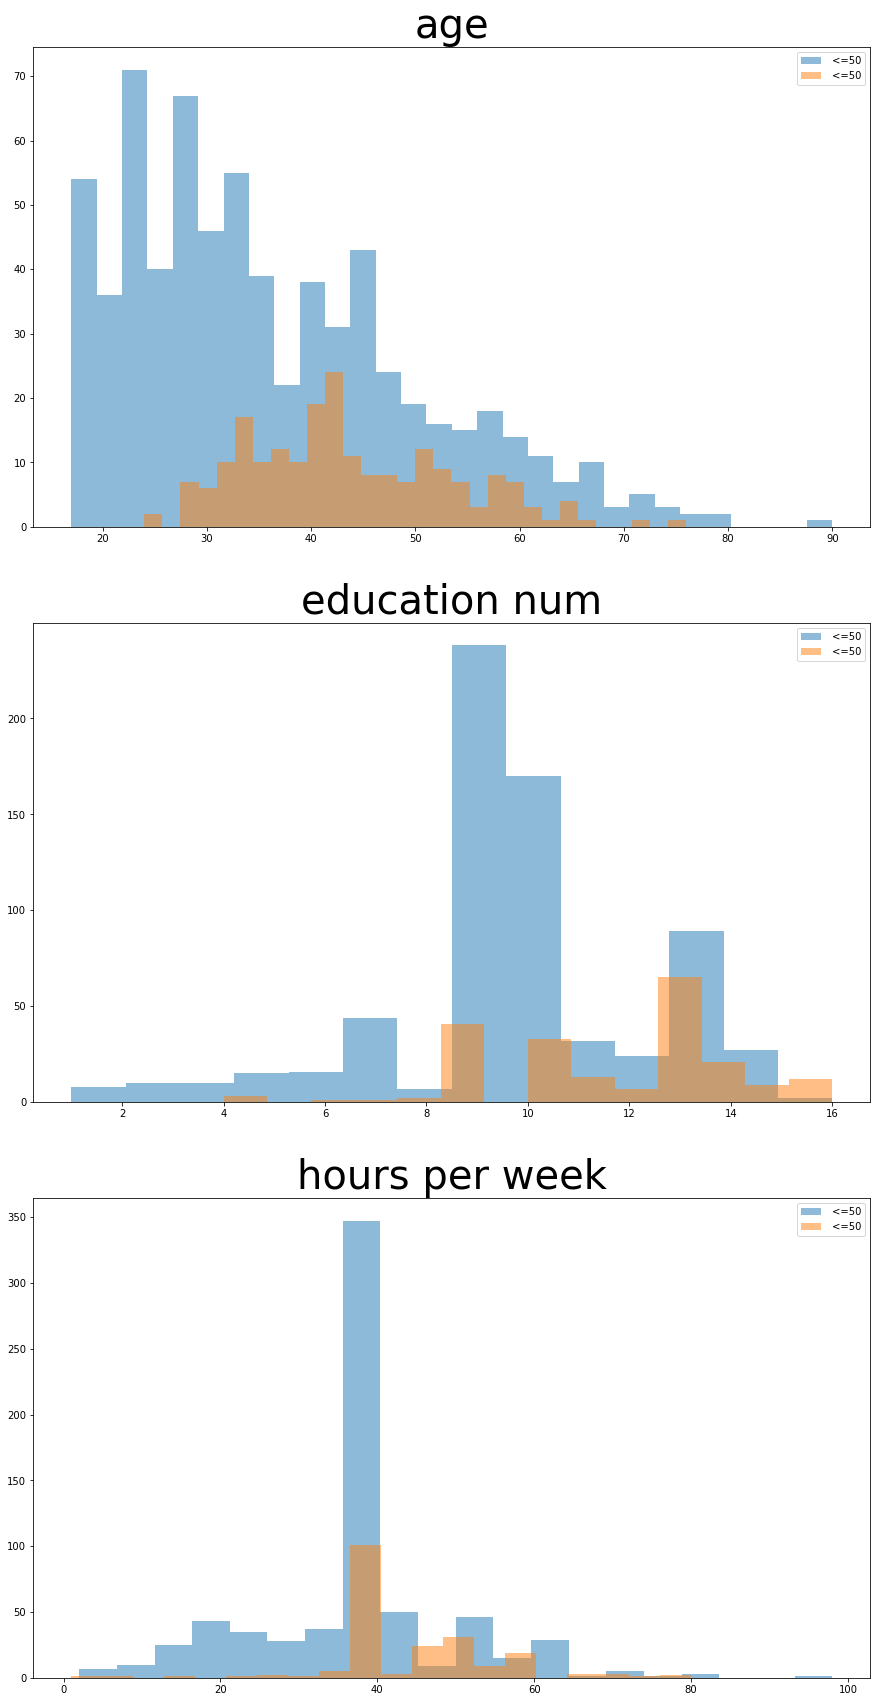

In [13]:
# Plotting histograms of numerical attributes to visualize and help see which method to use (Gaussian or KDE)

# Separating on class labels first
LESS_EQ50 = " <=50K"
GREATER50 = " >50K"
training_lessEq_50 = (training_data.loc[training_data["label"] == LESS_EQ50])
training_greater_50 = (training_data.loc[training_data["label"] == GREATER50])

# Initialize plot
figure, axis = plt.subplots(3,1)
figure.set_size_inches(15,30)

# For "age" column
axis[0].hist(training_lessEq_50["age"], bins = 30, alpha = 0.5, label = " <=50")
axis[0].hist(training_greater_50["age"], bins = 30, alpha = 0.5, label = " <=50")
axis[0].set_title("age", fontsize = 40)
axis[0].legend(loc = "upper right")


# For "education num" column
axis[1].hist(training_lessEq_50["education num"], bins = 14, alpha = 0.5, label = " <=50")
axis[1].hist(training_greater_50["education num"], bins = 14, alpha = 0.5, label = " <=50")
axis[1].set_title("education num", fontsize = 40)
axis[1].legend(loc = "upper right")

# For "hours per week" column
axis[2].hist(training_lessEq_50["hours per week"], bins = 20, alpha = 0.5, label = " <=50")
axis[2].hist(training_greater_50["hours per week"], bins = 20, alpha = 0.5, label = " <=50")
axis[2].set_title("hours per week", fontsize = 40)
axis[2].legend(loc = "upper right")


We used kernel bandwidth = 3 (3-12 gives same output). We see the model was able to correctly identify instances where income is less than or equal to 50K much better this time but correctly identifying instances where income is greater than 50K deproved. Accuracy dropped by 0.02 and F1 score seems to be almost the same (slightly lower). 

If our model's goal was more focused towards identifying those with less than or equal to 50K, then this model would be a better option. But since there is no information on the importance on individual labels, our previous model would be the better choice due to better evaluation.

Observing the histograms of numerical attributes, we do not see all the distributions to be Gaussian (e.g. " <=50" attributes for attribute "age" shows a skew to the right). So what would be best is to pick numerical attributes that would fit the Gaussian distribution to use the Gaussian NB while the other numerical attributes use KDE NB. This would be able to make the model performance to increase as now we do not blindly assume distributions for numerical attributes. One way to check for Gaussian distribution is to use scipy normaltest function and depending on the alpha you determine which would test for pvalue signifiance, we can find which attribute fits the Gaussian Distribution or not.

#### QUESTION (b)

In [14]:
def k_fold_evaluation(k, data):
    """
    Parameters:
        - k: number of folds
        - data: entire dataset 
        
    Steps:
    1) Shuffle dataset (ONLY HERE AND NOT DURING ITERATION)
    2) Split dataset into 10 folds for each class(groups)
    3) Iterate through each fold being the test set while the rest is training set
        - Each iteration we will train/test/evaluate (Gaussian NB)
        - We want to find accuracy, recall and specificity
    4) Average the sum of all the scores we found for respective evaluation metric
        - This will give the evaluation score for this cross validation
    
    Return average accuracy, recall and specificity for k fold
    """
    
    # Shuffle dataset (Applied random state to fix the randomization so we can compare results accurately)
    #   - 
    data = shuffle(data, random_state= 55)
    data.reset_index(inplace = True, drop = True)
    
    # Set number of folds
    fold = KFold(n_splits=k)
    
    #Variables we want to keep track of
    accuracy = 0
    recall = 0
    specificity = 0
    
    # Iterate every cross validation of kfolds and evaluate
    for train_i, test_i in fold.split(data):
        X_train, X_test = data.iloc[train_i,:-1], data.iloc[test_i,:-1]
        y_train, y_test = data.iloc[train_i,-1], data.iloc[test_i,-1]
        
        # Train new model
        NB_dict = train(X_train, y_train, num_att, nom_att)
        
        # Predict with new model
        y_pred, y_pred_prob = predict(NB_dict, X_test, num_att, nom_att)
        
        # Evaluate new model
        con_mat, acc, f1 = evaluate(y_test, y_pred)
        print('-' * 50)
        
        # Get accuracy, recall and specificity
        accuracy += acc
        tp, fn, fp, tn = con_mat.ravel()
        recall += tp / (tp + fn)
        specificity += tn / (tn + fp)
    
    # Average out the evaluation scores
    accuracy /= k
    recall /= k
    specificity /= k
    
    return accuracy, recall, specificity
    
    

In [15]:
# Now we call the function and find out the results

# Get the entire dataset as a whole
data = pd.read_csv(filename, sep = ',')


# Find average accuracy, recall and specificity for 10-fold cross validation
accuracy_kfold, recall_kfold, specificity_kfold = k_fold_evaluation(10, data)
print("For 10-fold cross validation:\nAverage accuracy: ", accuracy_kfold
      , "\nAverage recall: ", recall_kfold
      , "\nAverage specificity: ", specificity_kfold)



Confusion Matrix:
[[61 14]
 [ 4 21]]
Accuracy:  0.82
F1 score:  0.8714285714285714
--------------------------------------------------
Confusion Matrix:
[[65 11]
 [ 6 18]]
Accuracy:  0.83
F1 score:  0.8843537414965986
--------------------------------------------------
Confusion Matrix:
[[64 16]
 [ 6 14]]
Accuracy:  0.78
F1 score:  0.8533333333333333
--------------------------------------------------
Confusion Matrix:
[[64  7]
 [10 19]]
Accuracy:  0.83
F1 score:  0.8827586206896552
--------------------------------------------------
Confusion Matrix:
[[60 17]
 [ 8 15]]
Accuracy:  0.75
F1 score:  0.8275862068965517
--------------------------------------------------
Confusion Matrix:
[[69  5]
 [ 9 17]]
Accuracy:  0.86
F1 score:  0.9078947368421053
--------------------------------------------------
Confusion Matrix:
[[57 14]
 [ 8 21]]
Accuracy:  0.78
F1 score:  0.8382352941176471
--------------------------------------------------
Confusion Matrix:
[[77  9]
 [ 3 11]]
Accuracy:  0.88
F1 score:

In [16]:
# Find average accuracy, recall and specificity for 2-fold cross validation
accuracy_kfold, recall_kfold, specificity_kfold = k_fold_evaluation(2, data)
print("For 2-fold cross validation:\nAverage accuracy: ", accuracy_kfold
      , "\nAverage recall: ", recall_kfold
      , "\nAverage specificity: ", specificity_kfold)

Confusion Matrix:
[[313  66]
 [ 36  85]]
Accuracy:  0.796
F1 score:  0.8598901098901099
--------------------------------------------------
Confusion Matrix:
[[336  54]
 [ 34  76]]
Accuracy:  0.824
F1 score:  0.8842105263157896
--------------------------------------------------
For 2-fold cross validation:
Average accuracy:  0.81 
Average recall:  0.8436979906636899 
Average specificity:  0.6966942148760331


We know that, in general, more folds means we have more training data which means we should improve our evaluation, and we see here that the 10-fold does have slightly improved evaluation scores (though it is not significant). Comparing the evaluation metrics, we see that the accuracy is about the same for both kfold, but due to the unbalanced data where there are much more positive case (" <=50") instances, this information may not be reliable as the influence of positive case instances would be much higher. We will use accuracy just as a gauge of how well our model is able to get correct responses. More importantly, we will focus on recall and specificity. Recall is the proportion of true positive cases the model was able to detect while specificity is the same but for true negative cases. We see the effect of recall does not change as much due to the large training data there is for positive case. So a split of 2 or 10 would still leave quite a number of data for model to train. The same almost goes for negative cases, however, since it is still much lower than that of positive cases, we would see a bigger drop in specificity when we do 2 fold instead of 10 fold at (~3% in this case).